In [10]:
%pylab inline
from region.image import Image
from outputMake import *
from utils import *
from warping import *
from harris import *
from skimage.color import rgb2gray
import heapq

np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['show', 'imshow', 'imsave', 'resize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
def dispPtsOnImg(im, results, tag=False):
    dispPtsOnImgRC(im, results[:, 0], results[:, 1], tag)

def dispPtsOnImgRC(im, rowInds, colInds, tag=False):
    assert len(rowInds) == len(colInds)
    plt.imshow(im)
    plt.plot(rowInds, colInds, 'bo')
    if tag:
        for ind in range(len(rowInds)):
            x, y = rowInds[ind], colInds[ind]
            plt.text(x, y, str(ind), bbox=dict(facecolor='blue', alpha=0.5))
            plt.text(x, y, "%d-%d" % (x,y), bbox=dict(facecolor='red', alpha=0.5))
#     plt.waitforbuttonpress()
#     plt.close()

In [19]:
imSproul0 = Image.fromPath("../curated_sample_imgs/lower_sproul/lower_sproul_00.jpg", 0.10)
imSproul0.readCoordsIn("../curated_sample_imgs/lower_sproul/2_lower_sproul_00.txt")
imSproul0.pts = imSproul0.pts * 0.25

imSproul1 = Image.fromPath("../curated_sample_imgs/lower_sproul/lower_sproul_01.jpg", 0.10)
imSproul1.readCoordsIn("../curated_sample_imgs/lower_sproul/2_lower_sproul_01.txt")
imSproul1.pts = imSproul0.pts * 0.25

/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
res = get_harris_corners(imSproul0.imArr[:,:,0])

In [189]:
dispPtsOnImgRC(imSproul0.imArr, res[1][1], res[1][0])

In [21]:
class HarrisInfo:
    def __init__(self, x, y, radius):
        self.x = x
        self.y = y
        self.radius = radius
    
    def __repr__(self):
        return "HarrisInfo(x: %s, y: %s, r: %s)" % (self.x, self.y, self.radius)
        
class CleanHeap:
    def __init__(self, key = lambda x: x):
        self.heap = []
        self.key = key
        
    def push(self, item):
        formattedItem = (self.key(item), item)
        heapq.heappush(self.heap, formattedItem)

    def pop(self):
        val, item = heapq.heappop(self.heap)
        return item
    
    def pushpop(self, item):
        formattedItem = (self.key(item), item)
        val, item = heapq.heappushpop(self.heap, formattedItem)
        return item
    
    def length(self):
        return len(self.heap)

class LimitedHeap2(CleanHeap):
    def __init__(self, limit, key = lambda x: x):
        self.limit = limit
        CleanHeap.__init__(self, key)
    
    def push(self, item):
        if self.length() < self.limit:
            CleanHeap.push(self, item)
        else:
            CleanHeap.pushpop(self, item)

class LimitedHeap:
    def __init__(self, limit):
        self.limit = limit
        self.heap = []
    
    def push(self, item):
        if len(self.heap) < self.limit:
            heapq.heappush(self.heap, item)
        else:
            heapq.heappushpop(self.heap, item)
    
    def pop(self):
        return heapq.heappop(self.heap)

In [18]:
testHeap = LimitedHeap(3)

testHeap.push(1)
testHeap.push(2)
testHeap.push(3)
testHeap.push(4)

testHeap.pop()

2

In [48]:
im = imSproul0
desiredNs = 200
cRobust = 0.9

def findFeatures(im, desiredNs = 200, cRobust = 0.9):

    imArrGray = rgb2gray(im.imArr)

    allH, harrisCornersRowsCols = get_harris_corners(imArrGray[:,:])

    harrisCornersCoords = harrisCornersRowsCols.T

    harrisCornersValues = allH[harrisCornersRowsCols[0], harrisCornersRowsCols[1]]

    harrisCornersCoordsCt = len(harrisCornersCoords)
    rowOnes = np.array([[1, 0]] * harrisCornersCoordsCt).T
    colOnes = 1 - rowOnes
    valOnes = np.ones(harrisCornersCoordsCt)
    
#     print("harrisCornersRowsCols", harrisCornersRowsCols.shape)
#     print("rowOnes", rowOnes.shape)
#     print("colOnes", colOnes.shape)

    pointsHeap = LimitedHeap(limit = desiredNs)

    for i in range(harrisCornersCoordsCt):
        currRow, currCol = harrisCornersCoords[i]
        currVal = harrisCornersValues[i]
        # print(harrisCornersRowsCols)
        diffRowsCols = harrisCornersRowsCols - (rowOnes * currRow + colOnes * currCol)
        norms = np.linalg.norm(diffRowsCols, axis=0)
        norms[i] = float("inf")

        # harrisCornersValues[closestCoordID]

        #### decide which ids to filter out via cRobust

        diffVals = cRobust * harrisCornersValues - (valOnes * currVal)
        # print(diffVals)

        robustFailCoords = np.argwhere(diffVals <= 0)
        # print(robustFailCoords)

        norms[robustFailCoords] = float("inf")
        # print(diffVals)

    #     for i in range(len(norms)):
    #         print("norms:", i, norms[i], diffVals[i], harrisCornersCoords[i])

        closestCoordId = np.argmin(norms)
        # print(closestCoordID)

        newHarrisInfo = HarrisInfo(currCol, currRow, norms[closestCoordId])
    #     print(newHarrisInfo)

    #     print(pointsHeap.heap)
        pointsHeap.push((newHarrisInfo.radius, i, newHarrisInfo))
        # print("test")
    
#     for i in heapq.nlargest(200, pointsHeap.heap):
#         print(i)
#     return
    finalNHarrisCoords = [res[2] for res in pointsHeap.heap]

    coordsRowsCols = np.array([[info.y, info.x] for info in finalNHarrisCoords]).T

    return coordsRowsCols

coordsRowsCols = findFeatures(imSproul1, 200, 0.9)
coordsRowsCols

array([[127, 150,  83, 122, 140, 107, 173,  79,  26,  53,  63, 137,  66,
         50,  73,  79, 134,  46,  71,  57,  57,  76,  44, 129, 164, 124,
         28,  96,  23,  51,  74,  56,  63, 140,  81, 106, 147,  23,  95,
        157,  67,  99, 124, 111, 135,  89,  74, 151, 145,  25,  56, 105,
        132,  41, 103, 102, 162,  95,  83, 174, 112, 100,  87,  76, 131,
         73,  32,  38, 145, 115,  94,  88,  71, 158,  22, 115,  35, 171,
        104,  67,  71,  97, 156,  21, 156, 151,  44,  99, 112, 155,  64,
         87, 164, 136,  26, 131, 143, 164, 119, 170,  99, 170,  50, 102,
        143, 117, 163,  71,  59, 120, 115,  87,  61,  34,  87,  27, 115,
        120, 162,  51, 147,  60, 136,  88,  41, 148, 115, 105,  48,  21,
        147,  99,  86, 168, 150, 107, 113, 168, 122,  60,  61,  34, 150,
         94,  33,  55,  43, 167,  39, 147, 114, 174,  52, 157,  75,  59,
        131,  37,  28, 175,  97,  58,  87, 135,  55,  28, 147,  45,  27,
        144,  55, 100,  97, 119, 103, 155,  63,  74

In [188]:
finalNHarrisCoords = [res[2] for res in pointsHeap.heap]
finalNHarrisCoords

[HarrisInfo(h: 0.9236962358001735, x: 159, y: 51, r: 10.44030650891055),
 HarrisInfo(h: 0.5908709859506609, x: 109, y: 33, r: 10.44030650891055),
 HarrisInfo(h: 0.0017246817704793425, x: 366, y: 35, r: 10.44030650891055),
 HarrisInfo(h: 1.3993360785480673, x: 78, y: 57, r: 10.63014581273465),
 HarrisInfo(h: 0.7951280502389632, x: 224, y: 33, r: 10.63014581273465),
 HarrisInfo(h: 1.0034015715812088, x: 277, y: 140, r: 10.63014581273465),
 HarrisInfo(h: 1.2318646021201278, x: 307, y: 150, r: 11.045361017187261),
 HarrisInfo(h: 0.13332082587786293, x: 32, y: 83, r: 10.816653826391969),
 HarrisInfo(h: 0.8318348981958664, x: 230, y: 92, r: 10.770329614269007),
 HarrisInfo(h: 2.0349953147951845, x: 335, y: 78, r: 10.770329614269007),
 HarrisInfo(h: 1.100385384790551, x: 271, y: 170, r: 10.770329614269007),
 HarrisInfo(h: 1.3974315290331194, x: 154, y: 146, r: 10.816653826391969),
 HarrisInfo(h: 0.34285451970269537, x: 21, y: 64, r: 11.045361017187261),
 HarrisInfo(h: 1.5384246892536857, x: 1

Populating the interactive namespace from numpy and matplotlib


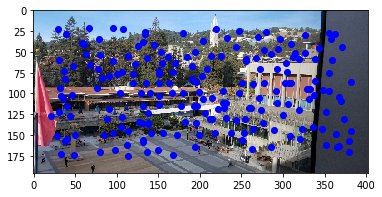

In [41]:
def t12():
    coordsRowsCols = findFeatures(imSproul1, 200, 0.9)
    dispPtsOnImgRC(imSproul0.imArr, coordsRowsCols[0], coordsRowsCols[1])

t12()

/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1428: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


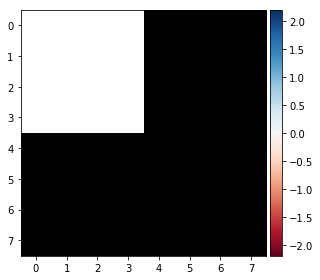

In [49]:
"""
given a point and a pic
grab an 40x40 patch from the surrounding area of the point
scale it down 8x8

"""

ptCoordXY = coordsRowsCols.T[1]
im = imSproul0

from skimage.transform import resize

def createDescriptor(ptCoordXY, im):
    assert ptCoordXY[0] < im.width, "input X coords too big for im width (%s): %s" % (im.width, ptCoordXY[0])
    assert ptCoordXY[1] < im.height, "input Y coords too big for im height (%s): %s" % (im.height, ptCoordXY[1])
    
    imArr = im.imArr
    # dispPtsOnImg(imArr, np.array([ptCoordXY]))
    origSize = 40
    finalSize = 8
    
#     print(ptCoordXY)
    
    rowBef = ptCoordXY[1] - origSize // 2
    adjRowBef = max(0, rowBef)
    rowAft = ptCoordXY[1] + origSize // 2
    adjRowAft = min(rowAft, im.height - 1)
    colBef = ptCoordXY[0] - origSize // 2
    adjColBef = max(0, colBef)
    colAft = ptCoordXY[0] + origSize // 2
    adjColAft = min(colAft, im.width - 1)
    
#     assert rowBef >= 0 and colBef >= 0
#     assert rowAft < im.height and colAft < im.width
    
#     print("rowBefs:", rowBef, adjRowBef)
#     print("rowAfts:", rowAft, adjRowAft)
#     print("colBefs:", colBef, adjColBef)
#     print("colAfts:", colAft, adjColAft)
    
    retrievedPatch = imArr[adjRowBef : adjRowAft + 1, adjColBef : adjColAft + 1]
    
    retrievedPaddedPatch = np.zeros((rowAft - rowBef + 1, colAft - colBef + 1, 3))
    
    padRowInd = adjRowBef - rowBef
    padColInd = adjColBef - colBef
    
    
    rowSize, colSize = retrievedPatch.shape[:2]
#     print("pads:", padRowInd, padColInd)
#     print("retrievedPatch:", retrievedPatch.shape)
#     print("rowSize:", rowSize, "colSize:", colSize)
#     print("retrivedPaddedPatch:", retrievedPaddedPatch[padRowInd : padRowInd + rowSize, padColInd : padColInd + colSize].shape)
    retrievedPaddedPatch[padRowInd : padRowInd + rowSize, padColInd : padColInd + colSize] = retrievedPatch
    
    finalPatch = resize(retrievedPaddedPatch, (finalSize, finalSize))
    
    inpAry = finalPatch
    origAve = inpAry.mean()
    newAry = (inpAry - origAve) * 1 / inpAry.std()
    
    return newAry

viewImage(createDescriptor(np.array([im.width - 1, im.height - 1]), im))
# viewImage(createDescriptor(np.array([im.width - 2, 0]), im))

# ptCoordXY
# createDescriptor(ptCoordXY, imArr)
# viewImage(createDescriptor(ptCoordXY, im))

In [301]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([[7, 7], [7, 7]])
a[0, 0] = b
a

ValueError: setting an array element with a sequence.

In [92]:
def auto_findH(im1, im2, desiredNs = 200, cRobust = 0.9):
    featuresIm1RC = findFeatures(im1, desiredNs, cRobust)
    featuresIm2RC = findFeatures(im2, desiredNs, cRobust)
    # dispPtsOnImgRC(im2.imArr, featuresIm2[1], featuresIm2[0])
    
    """Note: featuresImN = X, Y"""
    
    featuresIm1YX = featuresIm1RC.T
    featuresIm2YX = featuresIm2RC.T
    
    flipCoords = lambda x: np.array([x[1], x[0]])
    
    subFn1 = lambda x: createDescriptor(flipCoords(x), im1)
    descriptorsIm1YX = np.array(list(map(subFn1, featuresIm1YX)))
    subFn2 = lambda x: createDescriptor(flipCoords(x), im2)
    descriptorsIm2YX = np.array(list(map(subFn2, featuresIm2YX)))
    
#     print(descriptorsIm1YX.shape, descriptorsIm2YX.shape)
#     print(descriptorsIm1YX, descriptorsIm2YX)
    
    
    flatDescIm1YX = np.array(list(map(np.ndarray.flatten, descriptorsIm1YX)))
    flatDescIm2YX = np.array(list(map(np.ndarray.flatten, descriptorsIm2YX)))
    distResult = dist2(flatDescIm1YX, flatDescIm2YX)
    
    fPairs1t2 = findFeaturePairs(featuresIm1YX, featuresIm2YX, distResult)
    fPairs2t1 = findFeaturePairs(featuresIm2YX, featuresIm1YX, distResult.T)
    
    fPairsTotal = fPairs1t2 + fPairs2t1
    
    """Q: how to cycle through 4 points through """
    
def findFeaturePairs(featuresImAYX, featuresImBYX, distAB, matchThreshold = 0.5):
    fPairs = []
    
    findMinim2 = lambda a: np.argpartition(a, 2)[:2]
    
    
    for i in range(len(featuresImAYX)):
        matRow = distAB[i]
#         print(len(featuresIm2YX))
#         print(featuresIm2YX)
#         break
        currImAYX = featuresImAYX[i]
        
        NN1stInd, NN2ndInd = findMinim2(matRow)
        
        NN1stYX = featuresImBYX[NN1stInd]
        NN2ndYX = featuresImBYX[NN2ndInd]
        
        NN1stDistVal = matRow[NN1stInd]
        NN2ndDistVal = matRow[NN2ndInd]
#         print(currImAYX)
#         print("inds:", NN1stInd, NN2ndInd)
#         print("distVal:", NN1stDistVal, NN2ndDistVal)
#         print(NN1stYX, NN2ndYX)
        
#         print(descriptorsIm1YX[i].shape)
        
#         viewImage(descriptorsIm1YX[i])
#         viewImage(descriptorsIm2YX[NN1stInd])
#         viewImage(descriptorsIm2YX[NN2ndInd])
#         print(matRow)
        
        if NN1stDistVal/NN2ndDistVal <= matchThreshold:
            fPairs.append((currImAYX, NN1stYX))
    
    return fPairs
    
    
auto_findH(imSproul0, imSproul1)

/Users/reginaongowarsito/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(array([136, 123]), array([131, 254])), (array([ 30, 378]), array([ 22, 107])), (array([ 59, 190]), array([ 51, 327])), (array([ 41, 377]), array([ 22, 107])), (array([147, 134]), array([143, 264])), (array([122, 183]), array([120, 319])), (array([103, 117]), array([ 99, 247])), (array([156,  84]), array([147, 218])), (array([128, 166]), array([126, 300])), (array([ 27, 116]), array([ 25, 247])), (array([152, 106]), array([147, 238])), (array([ 96, 348]), array([101, 208])), (array([ 25, 247]), array([ 27, 116])), (array([105, 271]), array([108, 162])), (array([131, 254]), array([136, 123])), (array([ 99, 247]), array([103, 117])), (array([117, 261]), array([121, 133])), (array([120, 274]), array([124, 154])), (array([ 27, 180]), array([24, 37])), (array([ 51, 327]), array([ 59, 190])), (array([147, 238]), array([152, 106])), (array([143, 264]), array([147, 134])), (array([126, 300]), array([128, 166]))]


In [285]:
a = np.array([19, 53, 2, -9, 22])
a[np.argpartition(a, 2)[:2]]

array([-9,  2])

In [269]:
a = np.array([[1, 1], [2, 2]])
b = np.array([[4, 4], [4, 4]])
print(dist2(a, b))

a = np.array([[2, 2]])
b = np.array([[4, 4]])
dist2(a, b)

[[18. 18.]
 [ 8.  8.]]


array([[8.]])

In [95]:
rowOnes = np.array([[1, 0]] * harrisCornersCt).T
colOnes = 1 - rowOnes
colOnes

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]])

In [80]:
harrisCorners = harrisCornersRowsCols.T
harrisCorners

NameError: name 'harrisCornersRowsCols' is not defined

In [45]:
allH.shape
allH[harrisCorners[0], harrisCorners[1]]
# harrisCorners.T

array([0.00269368, 0.00120775, 1.03567858, ..., 0.62170224, 0.5247835 ,
       0.68971716])

In [19]:
np.argwhere(res[0] > 1)

array([[  0,   0],
       [  0,   1],
       [  1,   0],
       [  1,   1],
       [  1, 346],
       [ 22, 216],
       [ 22, 217],
       [ 23, 216],
       [ 23, 296],
       [ 26, 217],
       [ 29,  65],
       [ 30,  65],
       [ 32,  66],
       [ 32,  67],
       [ 33,  66],
       [ 34, 236],
       [ 35, 236],
       [ 35, 237],
       [ 36, 236],
       [ 36, 237],
       [ 37, 244],
       [ 38, 344],
       [ 40, 340],
       [ 40, 341],
       [ 41, 328],
       [ 41, 329],
       [ 41, 330],
       [ 41, 331],
       [ 42, 329],
       [ 42, 330],
       [ 48,   4],
       [ 49, 203],
       [ 49, 204],
       [ 50, 203],
       [ 50, 204],
       [ 52,  66],
       [ 52,  67],
       [ 52, 166],
       [ 52, 167],
       [ 52, 252],
       [ 52, 253],
       [ 53, 166],
       [ 53, 167],
       [ 54,  56],
       [ 54,  57],
       [ 54, 246],
       [ 54, 247],
       [ 55,  56],
       [ 55, 177],
       [ 55, 178],
       [ 55, 246],
       [ 55, 247],
       [ 56,

In [20]:
res[1]
"""
reference:
    res[1][0] = np.argwhere(res[0] > 1)[0]
"""

array([[175, 175, 175, ...,  21,  21,  21],
       [371, 363, 255, ...,  53,  48,  39]])

In [41]:
test = np.array([
    [1, 2, 3],
    [4, 5, 6]
])

test[np.array([0]), np.array([2])]

array([3])

TypeError: heap argument must be a list

In [371]:
a = {(129,  54),
 (155,  93),
 ( 73,  36),
 (127,  21),
 (145, 114),
 ( 98, 199),
 (168,  42),
 ( 76, 212),
 ( 35, 284),
 ( 48, 277),
 ( 56, 162),
 (147, 141),
 ( 71,  77),
 ( 47, 204),
 ( 63, 154),
 ( 76, 100),
 (135, 138),
 ( 53, 286),
 ( 61, 275),
 ( 65, 129),
 ( 53, 257),
 ( 82, 111),
 ( 48, 253),
 (119, 236),
 (153, 191),
 (115, 132),
 ( 38, 131),
 ( 89, 340),
 ( 34, 219),
 ( 41, 310),
 ( 63, 304),
 ( 50, 153),
 ( 56, 162),
 (143, 347),
 ( 71,  77),
 (107, 204),
 (143, 264),
 ( 28,  39),
 ( 85, 338),
 (168,  42),
 ( 63,  37),
 (103, 151),
 (112, 205),
 ( 99, 289),
 (124, 138),
 ( 88, 251),
 ( 63, 170),
 (157,  38),
 (157, 114),
 ( 33, 233),
 ( 41, 310),
 (117, 261),
 (131, 254),
 ( 52,  63),
 (114, 151),
 (105,  35),
 (164, 365),
 ( 85, 338),
 ( 89, 180),
 (175, 156),
 ( 97, 233),
 (106, 178),
 ( 88, 151),
 ( 88, 151),
 (128, 106),
 ( 94,  32),
 ( 26, 279),
 ( 39, 145),
 (157, 380),
 (107, 204),
 (105,  35),
 ( 97, 292),
 ( 59, 209),
 (170, 136),
 ( 39, 104),
 ( 99, 180),
 ( 48,  79),
 (157, 380),
 ( 97, 355),
 ( 56, 184),
 ( 74, 305),
 ( 89, 340),
 (147, 238),
 ( 22, 107),
 (147, 141),
 (155, 321),
 ( 34, 358),
 ( 87, 120),
 (100, 235),
 (150,  50),
 ( 74, 106),
 ( 97, 292),
 (149, 364),
 (124, 135),
 ( 38, 131),
 (118, 259),
 (155, 321),
 (146, 284),
 (131,  88),
 (147, 141),
 ( 97, 228),
 (168,  98),
 ( 37, 204),
 ( 85, 338),
 (149, 364),
 ( 97, 292),
 (151, 372),
 (175, 369),
 ( 51, 329),
 (117, 261),
 (105,  35),
 ( 97, 292),
 ( 54,  80),
 ( 41, 310),
 ( 96, 290),
 ( 31, 201),
 ( 99, 180),
 (122, 352),
 (158, 132),
 ( 41, 310),
 (147, 141),
 ( 41, 359),
 (120, 274),
 ( 88, 231),
 ( 48, 277),
 (134, 127),
 (107, 204),
 ( 99,  75),
 ( 97, 228),
 ( 48,  73),
 (150, 172),
 ( 71,  77),
 (104, 368),
 (170, 136),
 (135, 195),
 (120, 319),
 (126, 300),
 (148,  96),
 (175, 369),
 ( 52,  39),
 ( 48, 277),
 ( 45, 343),
 (156,  65),
 ( 71,  77),
 ( 55, 226),
 ( 97, 228),
 ( 53, 116),
 (118, 259),
 ( 52,  63),
 (150, 172),
 ( 97, 228),
 (170,  80),
 ( 54,  80),
 (122, 352),
 ( 89, 351),
 ( 41, 310),
 (143, 206),
 ( 97, 228),
 ( 40,  52),
 (162, 112),
 (122, 352),
 ( 48, 277),
 ( 99, 140),
 (115, 177),
 ( 97, 228),
 ( 45, 343),
 (147, 218),
 ( 41, 310),
 ( 45, 343),
 (127, 294),
 ( 61,  96),
 ( 92,  93),
 (122, 352),
 (107, 204),
 ( 99,  75),
 (120, 319),
 ( 41, 310),
 ( 71,  77),
 (118, 355),
 (143, 206),
 ( 98, 199),
 ( 74, 106),
 (114, 151),
 ( 97, 228),
 (122, 352),
 (118, 355),
 (123, 125),
 (157, 380),
 ( 99, 180),
 (135, 195),
 (120, 270),
 ( 74, 106),
 (122, 352),
 ( 71,  77),
 (115,  40),
 ( 41, 310),
 ( 97, 228),
 (103, 151),
 ( 63, 170),
 (22 , 52)}

In [372]:
len(a)

129